# Bollinger Bands Strategy and Backtesting

Prepared by Samalie Piwan   
Email : spiwan@andrew.cmu.edu

## 1. Strategy Implementation

Load the libraries to be used in the project

In [557]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
import os
import csv
import backtesting
from backtesting import Backtest, Strategy
from tabulate import tabulate
from backtesting.lib import crossover, TrailingStrategy
backtesting.set_bokeh_output(notebook=False)

## 1. Backtesting

### 1.1 Loading API data

First, we set the initial parameters for loading the data. We also load the hourly data from the **Yahoo Finance** API.<br>
Because we cannot load data past 730 days from the API, we will load data from 20th October 2021 to 20th October 2023

In [690]:
forex_pair = "EURUSD=X"
interval = "1h"
start_date = '2021-10-21'
end_date = '2023-10-20'

In [691]:
price_data = yf.download(forex_pair, interval = interval, start = start_date)

[*********************100%%**********************]  1 of 1 completed


Next, we split the data into two datasets **insample_data** and **outsample_data**.
  - insample_data will contain data from October 2021 to October 2022.
  - outsample_data will contain data from October 2022 to October 2023

In [692]:
insample_data = pd.DataFrame(price_data.loc['2021-10-21' : '2022-10-21'].copy())
outsample_data = pd.DataFrame(price_data.loc['2022-10-22':'2023-10-20'].copy())

### 1.2 Backtesting Strategy Setup

For this strategy, we will focus on optimizing the hyperparameters below:
    
- Simple Moving Average (SMA) Window
- Standard Deviation

Define the Indicator(Bollinger Bands) and Buy / Sell Strategy that the backtesting.py library will optimize

In [693]:
def indicator(data, window, std_dev):
    bbands = ta.bbands(close = data.Close.s, length = window, std = std_dev)
    return bbands.to_numpy().T[:3]

class BollingerBandsStrategy(Strategy):
        
    sma_window = 60
    std = 2
    
    def init(self):
        self.bbands = self.I(indicator, self.data, self.sma_window, self.std)
        
    def next(self):
        super().next()
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]
        
        if self.position:
            if crossover(self.data.Close, upper_band):
                self.position.close()
        else:
            if crossover(lower_band, self.data.Close):
                self.buy()

Create and an instance of our Backtest class using:
- The **'insample_dataset'** from section 2
- Cash of $10,000
- Commission at 1%
- SMA window of 20
- Standard Deviation of 2

In [699]:
bt = Backtest(insample_dataset, BollingerBandsStrategy, cash=10_000, commission=0.01)
stats = bt.run()

Create a table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the backtest

In [700]:
pnl_backtest = np.cumsum(stats['_trades'])
pnl_backtest_val = pnl_backtest['PnL'].iloc[-1]

In [701]:
backtest_results_table = [["Peak Equity", stats['Equity Peak [$]']],
                          ["Final Equity",stats['Equity Final [$]']],
                          ["Sharpe Ratio", round(stats['Sharpe Ratio'], 5)], 
                          ["PnL", f"${round(pnl_backtest_val,3)}"],
                          ["Return %", f"{round(stats['Return [%]'], 3)}%"],
                          ["Win Rate [%]", f"{round(stats['Win Rate [%]'], 3)}%"],
                          ["Number of trades", len(stats['_trades'])]]
print(f"Backesting reults with investment of {10000} and commission of 1%\n")
print(tabulate(backtest_results_table, headers=["Result", "Value"]))                         

Backesting reults with investment of 10000 and commission of 1%

Result            Value
----------------  -----------------
Peak Equity       10000.0
Final Equity      6616.051642149087
Sharpe Ratio      0.0
PnL               $-3383.948
Return %          -33.839%
Win Rate [%]      9.677%
Number of trades  31


Plot the Close-to-Close equity lines

In [702]:
backtest_pnl = pd.DataFrame(stats['_trades']["PnL"].copy())
backtest_pnl["PnL CumSum"] = backtest_pnl["PnL"].cumsum()

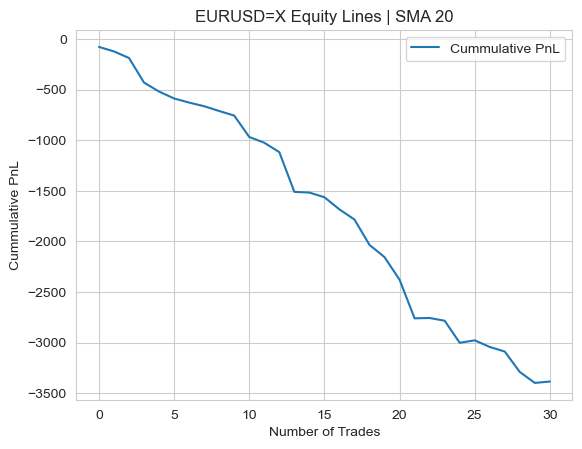

In [703]:
#Plot the figures with the trading signals
plt.title(forex_pair+" Equity Lines | SMA "+str(sma_window))
plt.plot(backtest_pnl.index, backtest_pnl["PnL CumSum"], label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

### 2.2 Optmizing strategy to select best-performing hyperparameters

Run the backesting.py **optimize()** function using the Simple Moving Average Window and Standard Deviation as the parameters to optmize

In [729]:
optimized_stats, heatmap = bt.optimize(
    sma_window = range(20, 71, 1),
    std = list(np.round(np.linspace(1, 3, 11), 1)),
    maximize = 'Equity Final [$]',
    return_heatmap = True
)

hm = heatmap.groupby(["sma_window", "std"]).mean().unstack()

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 561 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

Create a second table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the optimized backtest

In [730]:
pnl_optimized = np.cumsum(optimized_stats['_trades'])
pnl_optimized_val = pnl_optimized['PnL'].iloc[-1]

In [731]:
optimized_backtest_results_table = [["Peak Equity", optimized_stats['Equity Peak [$]']],
                                    ["Final Equity",optimized_stats['Equity Final [$]']],["Sharpe Ratio", round(optimized_stats['Sharpe Ratio'], 5)], 
                          ["PnL", f"${round(pnl_optimized_val,3)}"],
                          ["Return %", f"{round(optimized_stats['Return [%]'], 3)}%"],
                          ["Win Rate [%]", f"{round(optimized_stats['Win Rate [%]'], 3)}%"],
                          ["Number of trades", len(optimized_stats['_trades'])]]
print(f"Backesting reults with SMA Window and Standard Deviation optimized\n")
print(tabulate(optimized_backtest_results_table, headers=["Result", "Value"]))                         

Backesting reults with SMA Window and Standard Deviation optimized

Result            Value
----------------  -----------------
Peak Equity       10000.0
Final Equity      8697.760105600953
Sharpe Ratio      0.0
PnL               $-1302.24
Return %          -13.022%
Win Rate [%]      9.091%
Number of trades  11


Plot the close-to-close equity lines

In [732]:
validate_pnl = pd.DataFrame(optimized_stats['_trades']["PnL"].copy())
validate_pnl["PnL CumSum"] = validate_pnl["PnL"].cumsum()

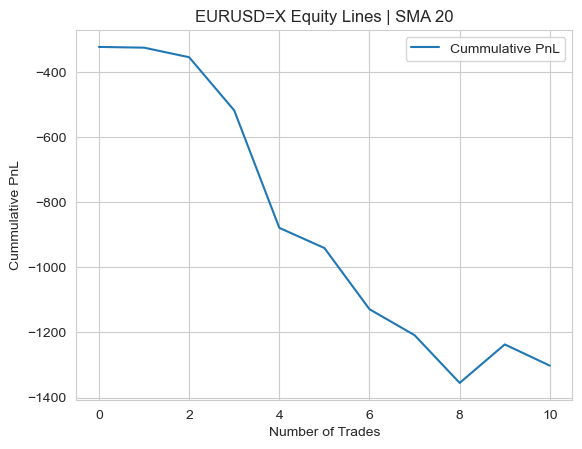

In [733]:
#Plot the figures with the trading signals
plt.title(forex_pair+" Equity Lines | SMA "+str(sma_window))
plt.plot(validate_pnl.index, validate_pnl["PnL CumSum"], label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

Plot a heatmap of the best-performing hyperparameters

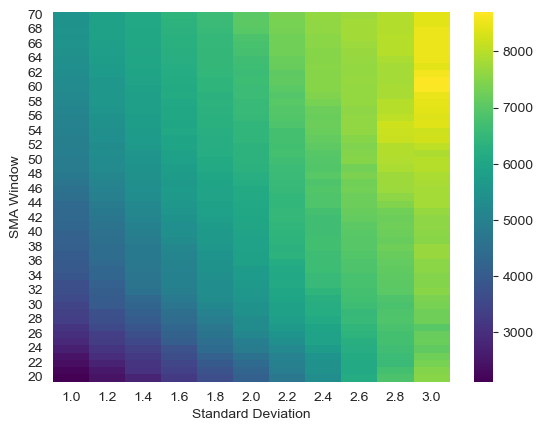

In [734]:
pricing_hm = sns.heatmap(hm[::-1], cmap='viridis')
pricing_hm.set(xlabel='Standard Deviation', ylabel='SMA Window')
plt.show()

### 2.3 Cross validation

Get the optimal parameters

In [735]:
optmized_std = optimized_stats['_strategy'].std
optimized_window = optimized_stats['_strategy'].sma_window

print(f"Optimal standard deviation is {optmized_std}")
print(f"Optimal SMA Window is {optimized_window}")

Optimal standard deviation is 3.0
Optimal SMA Window is 61


Run an instance of our Backtest class using  from section 2 using:
- The **'rerun_dataset'** from section 2
- Cash of $10,000
- Commission at 1%

In [736]:
class OptBollingerBandsStrategy(Strategy):
    
    sma_window = optimized_window
    std = optmized_std
    
    def init(self):
        self.bbands = self.I(indicator, self.data, self.sma_window, self.std)
        
    def next(self):
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]

        if self.position:
            if crossover(self.data.Close, upper_band):
                self.position.close()
        else:
            if crossover(lower_band, self.data.Close):
                self.buy()

In [737]:
bt_optimal = Backtest(outsample_data, OptBollingerBandsStrategy, cash=10_000, commission=0.01)
stats_optimal = bt_optimal.run()

Create a table with the Sharpe Ratio, Proft and Loss (PnL) and Return percentage from the backtest

In [738]:
pnl_rerun = np.cumsum(stats_optimal['_trades'])
pnl_rerun_val = pnl_rerun['PnL'].iloc[-1]

In [739]:
optimized_backtest_results_table = [["Peak Equity", stats_optimal['Equity Peak [$]']],["Final Equity",stats_optimal['Equity Final [$]']],
                                    ["Sharpe Ratio", round(stats_optimal['Sharpe Ratio'], 5)], 
                                      ["PnL", f"${round(pnl_rerun_val,3)}"],
                                      ["Return %", f"{round(stats_optimal['Return [%]'], 3)}%"],
                                      ["Win Rate [%]", f"{round(stats_optimal['Win Rate [%]'], 3)}%"],
                                      ["Number of trades", len(stats_optimal['_trades'])]]
print(f"Backesting optimized reults with investment of {10000} and commission of 1%\n")
print(tabulate(optimized_backtest_results_table, headers=["Result", "Value"]))                         

Backesting optimized reults with investment of 10000 and commission of 1%

Result            Value
----------------  ------------------
Peak Equity       10912.885153107643
Final Equity      10240.750189620256
Sharpe Ratio      0.36636
PnL               $240.75
Return %          2.408%
Win Rate [%]      54.545%
Number of trades  11


Plot Close to Close Equity Lines

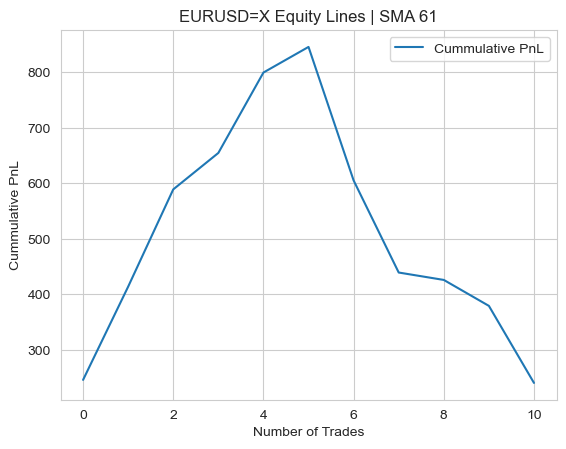

In [740]:
rerun_pnl = pd.DataFrame(stats_optimal['_trades']["PnL"].copy())
rerun_pnl["PnL CumSum"] = rerun_pnl["PnL"].cumsum()

#Plot the figures with the trading signals
plt.title(forex_pair+" Equity Lines | SMA "+str(optimized_window))
plt.plot(rerun_pnl.index, rerun_pnl["PnL CumSum"], label = "Cummulative PnL")
plt.xlabel("Number of Trades")
plt.ylabel("Cummulative PnL")
plt.legend(loc='upper right')
plt.show()

### 3. Bulk Backtesting and Cross-Validation + Saving Metrics

Create a list of the currency pairs to test

In [ ]:
currency_pairs = ['EURUSD=X', 'USDJPY=X', 'GBPUSD=X', 'AUDUSD=X', 'USDCAD=X', 'USDCHF=X', 'EURGBP=X', 'EURJPY=X', 'GBPJPY=X', 'EURCHF=X', 'USDNOK=X', 'USDCNY=X', 'EURCAD=X', 'USDHKD=X', 'USDSGD=X']

Download the data from the API for each and save it into a csv file

In [ ]:
for forex_pair in currency_pairs:
    
    data =  yf.download(forex_pair, interval="1wk", start='2005-01-01', end = '2022-12-31')

    #Seperate the data into two sets, 2005 to 2013 and 2014 to 2022
    backtest_dataset = pd.DataFrame(data.loc['2005-01-01' : '2013-12-31'].copy())
    rerun_dataset = pd.DataFrame(data.loc['2014-01-01':'2022-12-31'].copy())
    
    backtest_filename = "backtest"+forex_pair+".csv"
    rerun_filename = "rerun"+forex_pair+".csv"

    backtest_dataset.to_csv("backtestdata/"+backtest_filename)
    rerun_dataset.to_csv("rerundata/"+rerun_filename)

### 3.1 Backtest and save historical data

Define the function that will run the backtests for the currency pair list above using the strategy **BollingerBandsStrategy**. Backtest the 15 currency pairs with the bollinger bands strategy, using the saved historical data for 2005 to 2013 in the directory backtestdata/

In [ ]:
backtest_results = []
backtest_dir = 'backtestdata'
files = os.listdir(backtest_dir)

def backtest_strategy(param_cash, param_commission):
    index = 0
    while index < len(files):
        try:
            filename = backtest_dir+"/"+files[index]
            symbol = filename[21:27]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(data_df['Date'])
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, BollingerBandsStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run()
            backtest_results.append(list([symbol, stats]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
        
        finally:
            index += 1
            
    return backtest_results

In [ ]:
bulk_backtest_results = backtest_strategy(10_000, 0.01)

Save the **backtest** metrics into a list and write the data into a csv file

In [ ]:
backtest_metrics = []
header = ["Currency Pair", "Final Equity", "PnL", "Return Pct", "Sharpe Ratio", "Win Rate", "Profit Factor", "Number of Trades"]

for result in bulk_backtest_results:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    #We will write the currency pair, final equity, PnL, return pct, sharpe ratio, win rate, profit factor and number of trades 
    backtest_metrics.append(list([
        result[0],
        result[1]['Equity Final [$]'],
        result_pnl,
        result[1]['Return [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Win Rate [%]'],
        result[1]['Profit Factor'],
        len(result[1]['_trades'])
    ]))

Write the data to the file **backtest_metrics.csv**

In [ ]:
with open('backtest_metrics.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(backtest_metrics)

### 3.2 Cross-validate and save cross-validation data

Define the function that will run the backtests for the currency pair list above using the strategy **OptBollingerBandsStrategy**. Backtest the 15 currency pairs with the optimized bollinger bands strategy, using the saved data for 2013 to 2022 in the directory rerundata/

In [ ]:
validate_results = []
validate_dir = 'rerundata'
validate_files = os.listdir(validate_dir)

def validate_strategy(param_cash, param_commission):
    index = 0
    while index < len(validate_files):
        try:
            filename = validate_dir+"/"+validate_files[index]
            symbol = filename[15:21]
            
            file_data = pd.read_csv(filename)
            
            data_df = file_data.copy()
            data_df.index = pd.DatetimeIndex(data_df['Date'])
            data_df.sort_index(ascending=True, inplace=True)
            
            bt = Backtest(data_df, OptBollingerBandsStrategy, cash = param_cash, commission = param_commission)
            stats = bt.run()
            validate_results.append(list([symbol, stats]))
        
        except FileNotFoundError:
            print(f"File {filename} not found")
        
        except ValueError:
            continue
            
        finally:
            index += 1
            
    return validate_results

In [ ]:
bulk_validate_results = validate_strategy(10_000, 0.01)

Save the **validation** metrics into a list and write the data into a csv file

In [ ]:
validate_metrics = []
for result in bulk_validate_results:
    if(len(result[1]['_trades']) > 0):
        pnl_col = np.cumsum(result[1]['_trades']['PnL'])
        result_pnl = pnl_col.iloc[-1]
    else:
        result_pnl = 0

    #We will write the currency pair, final equity, PnL, return pct, sharpe ratio, win rate, profit factor and number of trades
    validate_metrics.append(list([
        result[0],
        result[1]['Equity Final [$]'],
        result_pnl,
        result[1]['Return [%]'],
        result[1]['Sharpe Ratio'],
        result[1]['Win Rate [%]'],
        result[1]['Profit Factor'],
        len(result[1]['_trades'])
    ]))

Write the data to the file **validation_metrics.csv**

In [ ]:
with open('validation_metrics.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(validate_metrics)